# Natual Language Processing (Part 1)

[Source: Dipanjan Sarkar via Medium](https://towardsdatascience.com/a-practitioners-guide-to-natural-language-processing-part-i-processing-understanding-text-9f4abfd13e72)

[Github](http://nbviewer.jupyter.org/github/dipanjanS/practical-machine-learning-with-python/blob/master/bonus%20content/nlp%20proven%20approach/NLP%20Strategy%20I%20-%20Processing%20and%20Understanding%20Text.ipynb)

We will be working with text data from news articles on technology, sports and world news. WE will covers some basics on how to scrape and retrieve these news articles from their website. 

Typically, any NLP-based problem can be solved by a methodical workflow that has a sequence of steps. The major steps are depicted in the following figure.

![Image](https://cdn-images-1.medium.com/max/1000/1*BiVCmiQtCBIdBNcaOKjurg.png)

We usually start with a corpus of text documents and follow standard processes of text wrangling and pre-processing, parsing and basic exploratory data analysis. Based on the initial insights, we usually represent the text using relevant feature engineering techniques. Depending on the problem at hand, we either focus on building predictive supervised models or unsupervised models, which usually focus more on pattern mining and grouping. Finally, we evaluate the model and the overall success criteria with relevant stakeholders or customers, and deploy the final model for future usage.

### Scraping News Articles for Data Retrieval
We will be scraping [inshorts](https://inshorts.com/), the website, by leveraging python to retrieve news articles. We will be focusing on articles on technology, sports and world affairs. We will retrieve one page’s worth of articles for each category. A typical news category landing page is depicted in the following figure, which also highlights the HTML section for the textual content of each article.


## Imports
First load up dependencies

In [1]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

%matplotlib inline

build a function that leverages `requests` to access and get the HTML content from the landing pages for each of the three news categories. Then we will use `BeautifulSoup` to parse and extract the news headline and article textual content for all the news articles in each category. 

In [2]:
seed_urls = ['https://inshorts.com/en/read/technology',
             'https://inshorts.com/en/read/sports',
             'https://inshorts.com/en/read/world']

In [3]:
def build_dataset(seed_urls):
    news_data = []
    for url in seed_urls:
        news_category = url.split('/')[-1]
        data = requests.get(url)
        soup = BeautifulSoup(data.content, 'html.parser')
        
        news_articles = [{'news_headline': headline.find('span', 
                                                         attrs={"itemprop": "headline"}).string,
                          'news_article': article.find('div', 
                                                       attrs={"itemprop": "articleBody"}).string,
                          'news_category': news_category}
                         
                            for headline, article in 
                             zip(soup.find_all('div', 
                                               class_=["news-card-title news-right-box"]),
                                 soup.find_all('div', 
                                               class_=["news-card-content news-right-box"]))
                        ]
        news_data.extend(news_articles)
        
    df =  pd.DataFrame(news_data)
    df = df[['news_headline', 'news_article', 'news_category']]
    return df

In [4]:
news_df = build_dataset(seed_urls)
news_df.head(10)

,news_headline,news_article,news_category
0,"OnePlus beats Apple, Samsung to become top pre...",OnePlus has emerged as the market leader in th...,technology
1,OnePlus opens new store in Bengaluru to increa...,Global smartphone maker OnePlus recently opene...,technology
2,"TRAI Chief's daughter threatened via e-mail, s...",After TRAI Chairman RS Sharma challenged hacke...,technology
3,Samsung quarterly revenue dips 4% amid slow sm...,Samsung Electronics posted a revenue of $52.24...,technology
4,Apple now has $243.7 billion in cash on hand,"World's most valuable company by market value,...",technology
5,Musk's idea of nuking Mars to make it warm won...,A NASA-backed research has refuted SpaceX CEO ...,technology
6,Google bans Android phones from having more th...,Google in its developer's blog on Monday said ...,technology
7,6-year-old YouTube star to launch own toy line...,A six-year-old boy named Ryan who has become a...,technology
8,"Apple posts strongest third quarter, nears $1 ...",Apple announced Tuesday that its profits rose ...,technology
9,WhatsApp launches 4-person group video calling,WhatsApp has officially released its group cal...,technology


In [5]:
# check the total number of news articles 

news_df.news_category.value_counts()

world         25
technology    25
sports        23
Name: news_category, dtype: int64

## Text Wragling & Pre-processing

In [6]:
import spacy
import pandas as pd
import numpy as np
import nltk
from nltk.tokenize.toktok import ToktokTokenizer
import re
from bs4 import BeautifulSoup
from contractions import CONTRACTION_MAP
import unicodedata

In [7]:
nlp = spacy.load('en', parse=True, tag=True, entity=True)
tokenizer = ToktokTokenizer()
stopword_list = nltk.corpus.stopwords.words('english')
stopword_list.remove('no')
stopword_list.remove('not')

### Removing HTML Tags

In [8]:
def strip_html_tags(text):
    soup = BeautifulSoup(text, "html.parser")
    stripped_text = soup.get_text()
    return stripped_text

strip_html_tags('<html><h2>Some important text</h2></html>')

'Some important text'

### Removing Accented Characters

In [9]:
def remove_accented_chars(text):
    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    return text

remove_accented_chars('Sómě Áccěntěd těxt')

'Some Accented text'

### Expanding Contractions

In [10]:
def expand_contractions(text, contraction_mapping=CONTRACTION_MAP):
    
    contractions_pattern = re.compile('({})'.format('|'.join(contraction_mapping.keys())), 
                                      flags=re.IGNORECASE|re.DOTALL)
    def expand_match(contraction):
        match = contraction.group(0)
        first_char = match[0]
        expanded_contraction = contraction_mapping.get(match)\
                                if contraction_mapping.get(match)\
                                else contraction_mapping.get(match.lower())                       
        expanded_contraction = first_char+expanded_contraction[1:]
        return expanded_contraction
        
    expanded_text = contractions_pattern.sub(expand_match, text)
    expanded_text = re.sub("'", "", expanded_text)
    return expanded_text

expand_contractions("Y'all can't expand contractions I'd think")

'You all cannot expand contractions I would think'

### Removing Sepecial Characters

In [11]:
def remove_special_characters(text, remove_digits=False):
    pattern = r'[^a-zA-z0-9\s]' if not remove_digits else r'[^a-zA-z\s]'
    text = re.sub(pattern, '', text)
    return text

remove_special_characters("Well this was fun! What do you think? 123#@!", 
                          remove_digits=True)

'Well this was fun What do you think '

### Stemming

Stemming is the process of obtaining the base form of a word from its inflected form. Stemming help us in standardizing words to their base or root stem, irrespeective of their inflections, whihc helps many applications like classifying or clustering text. 

In [12]:
def simple_stemmer(text):
    ps = nltk.porter.PorterStemmer()
    text = ' '.join([ps.stem(word) for word in text.split()])
    return text

simple_stemmer("My system keeps crashing his crashed yesterday, ours crashes daily")

'My system keep crash hi crash yesterday, our crash daili'

### Lemmatization

Lemmatization is very similar to stemming, where we remove word affixes to get to the base form of a word. However, the base form in this case is known as the root word, but not the root stem. The difference being that the root word is always a lexicographically correct word (present in the dictionary), but the root stem may not be so. Thus, root word, also known as the lemma, will always be present in the dictionary.

In [13]:
def lemmatize_text(text):
    text = nlp(text)
    text = ' '.join([word.lemma_ if word.lemma_ != '-PRON-' else word.text for word in text])
    return text

lemmatize_text("My system keeps crashing! his crashed yesterday, ours crashes daily")

'My system keep crash ! his crashed yesterday , ours crash daily'

### Removing Stopwords

In [14]:
def remove_stopwords(text, is_lower_case=False):
    tokens = tokenizer.tokenize(text)
    tokens = [token.strip() for token in tokens]
    if is_lower_case:
        filtered_tokens = [token for token in tokens if token not in stopword_list]
    else:
        filtered_tokens = [token for token in tokens if token.lower() not in stopword_list]
    filtered_text = ' '.join(filtered_tokens)    
    return filtered_text

remove_stopwords("The, and, if are stopwords, computer is not")    

', , stopwords , computer not'

## Bringing it all together - Building a Text Normalizer

In [15]:
def normalize_corpus(corpus, html_stripping=True, contraction_expansion=True,
                     accented_char_removal=True, text_lower_case=True, 
                     text_lemmatization=True, special_char_removal=True, 
                     stopword_removal=True, remove_digits=True):
    
    normalized_corpus = []
    # normalize each document in the corpus
    for doc in corpus:
        # strip HTML
        if html_stripping:
            doc = strip_html_tags(doc)
        # remove accented characters
        if accented_char_removal:
            doc = remove_accented_chars(doc)
        # expand contractions    
        if contraction_expansion:
            doc = expand_contractions(doc)
        # lowercase the text    
        if text_lower_case:
            doc = doc.lower()
        # remove extra newlines
        doc = re.sub(r'[\r|\n|\r\n]+', ' ',doc)
        # lemmatize text
        if text_lemmatization:
            doc = lemmatize_text(doc)
        # remove special characters and\or digits    
        if special_char_removal:
            # insert spaces between special characters to isolate them    
            special_char_pattern = re.compile(r'([{.(-)!}])')
            doc = special_char_pattern.sub(" \\1 ", doc)
            doc = remove_special_characters(doc, remove_digits=remove_digits)  
        # remove extra whitespace
        doc = re.sub(' +', ' ', doc)
        # remove stopwords
        if stopword_removal:
            doc = remove_stopwords(doc, is_lower_case=text_lower_case)
            
        normalized_corpus.append(doc)
        
    return normalized_corpus

In [16]:
# combining headline and article text
news_df['full_text'] = news_df['news_headline'].map(str)+ '. '+news_df['news_article']

In [17]:
# pre-process text and store the same
news_df['clean_text'] = normalize_corpus(news_df['full_text'])
norm_corpus = list(news_df['clean_text'])

In [18]:
# show a sample news arcle
news_df.iloc[1][['full_text', 'clean_text']].to_dict()

{'clean_text': 'oneplus open new store bengaluru increase offline presence global smartphone maker oneplus recently open offline authorise store bengaluru jayanagar th block july bangalore home market oneplus india always key market say vikas agarwal gm oneplus india line companys increase focus offline touchpoint india',
 'full_text': 'OnePlus opens new store in Bengaluru to increase offline presence. Global smartphone maker OnePlus recently opened an offline authorised store in Bengaluru at Jayanagar, 4th Block on July 28. "Bangalore is the home market for OnePlus in India and has always been our most key market," said Vikas Agarwal, GM, OnePlus India.This is in line with the company\'s increased focus on offline touchpoints in India.'}

In [19]:
news_df.to_csv('news.csv', index=False, encoding='utf-8')

## Understanding Language Syntax and Strucutre


Knowledge about the structure and syntax of language is helpful in many areas like text processing, annotation, and parsing for further operations such as text classification or summarization. Typical parsing techniques for understanding text syntax are mentioned below.

* Parts of Speech (POS) Tagging
* Shallow Parsing or Chunking
* Constituency Parsing
* Dependency Parsing


### Parts of Speach Tagging
Part sof Speech Tagging (POS) is the process of classifying and labeling POS tags for words. POS tags are used to annotate words and depict their POS, which is really helpful to perform analysis. 

In [20]:
# create a basic pre-processed corpus, dont lowercase to get POS context
corpus = normalize_corpus(news_df['full_text'], text_lower_case=False, 
                         text_lemmatization=False, 
                          special_char_removal=False)

In [26]:
corpus[1]

'OnePlus opens new store Bengaluru increase offline presence. Global smartphone maker OnePlus recently opened offline authorised store Bengaluru Jayanagar , 4th Block July 28. " Bangalore home market OnePlus India always key market , " said Vikas Agarwal , GM , OnePlus India.This line companys increased focus offline touchpoints India .'

In [27]:
# demo for POS tagging for sample news headline
sentence = str(news_df.iloc[1].news_headline)
sentence_nlp = nlp(sentence)

In [30]:
# POS tagging with Spacy
spacy_pos_tagged = [(word, word.tag_, word.pos_) for word in sentence_nlp]
pd.DataFrame(spacy_pos_tagged, columns=['Word', 'POS tag', 'Tag type'])

,Word,POS tag,Tag type
0,OnePlus,NNP,PROPN
1,opens,VBZ,VERB
2,new,JJ,ADJ
3,store,NN,NOUN
4,in,IN,ADP
5,Bengaluru,NNP,PROPN
6,to,TO,PART
7,increase,VB,VERB
8,offline,NN,NOUN
9,presence,NN,NOUN


In [45]:
# POS tagging with nltk
nltk_pos_tagged = nltk.pos_tag(sentence.split())
pd.DataFrame(nltk_pos_tagged, columns=['Word', 'POS tag'])

,Word,POS tag
0,OnePlus,CC
1,opens,VBZ
2,new,JJ
3,store,NN
4,in,IN
5,Bengaluru,NNP
6,to,TO
7,increase,VB
8,offline,JJ
9,presence,NN


### Shallow Parsing or Chucking

Shallow parsing, also known as light parsing or chunking , is a popular natural language processing technique of analyzing the structure of a sentence to break it down into its smallest constituents (which are tokens such as words) and group them together into higher-level phrases. This includes POS tags as well as phrases from a sentence.

In [34]:
from nltk.corpus import conll2000

data = conll2000.chunked_sents()
train_data = data[:10900]
test_data = data[10900:]

print(len(train_data), len(test_data))
print(train_data[1])

10900 48
(S
  Chancellor/NNP
  (PP of/IN)
  (NP the/DT Exchequer/NNP)
  (NP Nigel/NNP Lawson/NNP)
  (NP 's/POS restated/VBN commitment/NN)
  (PP to/TO)
  (NP a/DT firm/NN monetary/JJ policy/NN)
  (VP has/VBZ helped/VBN to/TO prevent/VB)
  (NP a/DT freefall/NN)
  (PP in/IN)
  (NP sterling/NN)
  (PP over/IN)
  (NP the/DT past/JJ week/NN)
  ./.)


In [35]:
from nltk.chunk.util import tree2conlltags, conlltags2tree

wtc = tree2conlltags(train_data[1])
wtc

[('Chancellor', 'NNP', 'O'),
 ('of', 'IN', 'B-PP'),
 ('the', 'DT', 'B-NP'),
 ('Exchequer', 'NNP', 'I-NP'),
 ('Nigel', 'NNP', 'B-NP'),
 ('Lawson', 'NNP', 'I-NP'),
 ("'s", 'POS', 'B-NP'),
 ('restated', 'VBN', 'I-NP'),
 ('commitment', 'NN', 'I-NP'),
 ('to', 'TO', 'B-PP'),
 ('a', 'DT', 'B-NP'),
 ('firm', 'NN', 'I-NP'),
 ('monetary', 'JJ', 'I-NP'),
 ('policy', 'NN', 'I-NP'),
 ('has', 'VBZ', 'B-VP'),
 ('helped', 'VBN', 'I-VP'),
 ('to', 'TO', 'I-VP'),
 ('prevent', 'VB', 'I-VP'),
 ('a', 'DT', 'B-NP'),
 ('freefall', 'NN', 'I-NP'),
 ('in', 'IN', 'B-PP'),
 ('sterling', 'NN', 'B-NP'),
 ('over', 'IN', 'B-PP'),
 ('the', 'DT', 'B-NP'),
 ('past', 'JJ', 'I-NP'),
 ('week', 'NN', 'I-NP'),
 ('.', '.', 'O')]

define a function to estract POS and check tags from sentences with chuncked annotations and a function to train multiple taggers with backoff tagers (e.g., unigram and bigram taggers)

In [41]:
def conll_tag_chunks(chunk_sents):
    tagged_sents = [tree2conlltags(tree) for tree in chunk_sents]
    return [[(t, c) for (w, t, c) in sent] for sent in tagged_sents]


def combined_tagger(train_data, taggers, backoff=None):
    for tagger in taggers:
        backoff = tagger(train_data, backoff=backoff)
    return backoff 

next we define class that takes takes in tagged sentences as training input, get their `(word, POS tag, Chuck tag)` and train a Bigram with an Unigram  Tagger as a backoff tager. 

In [42]:
from nltk.tag import UnigramTagger, BigramTagger
from nltk.chunk import ChunkParserI

# define the chunker class
class NGramTagChunker(ChunkParserI):
    
  def __init__(self, train_sentences, 
               tagger_classes=[UnigramTagger, BigramTagger]):
    train_sent_tags = conll_tag_chunks(train_sentences)
    self.chunk_tagger = combined_tagger(train_sent_tags, tagger_classes)

  def parse(self, tagged_sentence):
    if not tagged_sentence: 
        return None
    pos_tags = [tag for word, tag in tagged_sentence]
    chunk_pos_tags = self.chunk_tagger.tag(pos_tags)
    chunk_tags = [chunk_tag for (pos_tag, chunk_tag) in chunk_pos_tags]
    wpc_tags = [(word, pos_tag, chunk_tag) for ((word, pos_tag), chunk_tag)
                     in zip(tagged_sentence, chunk_tags)]
    return conlltags2tree(wpc_tags)
  
# train chunker model  
ntc = NGramTagChunker(train_data)

# evaluate chunker model performance
print(ntc.evaluate(test_data))

ChunkParse score:
    IOB Accuracy:  90.0%%
    Precision:     82.1%%
    Recall:        86.3%%
    F-Measure:     84.1%%


Our chunking model gets an accuracy of around 90% which is quite good! Let’s now leverage this model to shallow parse and chunk our sample news article headline which we used earlier, ___“US unveils world’s most powerful supercomputer, beats China”.___

In [46]:
chunk_tree = ntc.parse(nltk_pos_tagged)
print(chunk_tree)

(S
  OnePlus/CC
  (VP opens/VBZ)
  (NP new/JJ store/NN)
  (PP in/IN)
  (NP Bengaluru/NNP)
  (VP to/TO increase/VB)
  (NP offline/JJ presence/NN))


In [48]:
from IPython.display import display

## download and install ghostscript from https://www.ghostscript.com/download/gsdnld.html

# often need to add to the path manually (for windows)
os.environ['PATH'] = os.environ['PATH']+";C:\\Program Files\\gs\\gs9.09\\bin\\"

#display(chunk_tree)

## Dependency Parsing

__Dependency parsing__ we try to use dependency-based grammars to analyze and infer both _structure_ and _semantic dependencies_ and relationship between tokens in a sentence. 

The basic principle behind a dependency grammar is that in any sentence in the language, all words except one, have some relationship or dependency on other words in the sentence. The word that has no dependency is called the root of the sentence. The verb is taken as the root of the sentence in most cases. All the other words are directly or indirectly linked to the root verb using links , which are the dependencies.

In [49]:
dependency_pattern = '{left}<---{word}[{w_type}]--->{right}\n--------'
for token in sentence_nlp:
    print(dependency_pattern.format(word=token.orth_, 
                                  w_type=token.dep_,
                                  left=[t.orth_ 
                                            for t 
                                            in token.lefts],
                                  right=[t.orth_ 
                                             for t 
                                             in token.rights]))

[]<---OnePlus[nsubj]--->[]
--------
['OnePlus']<---opens[ROOT]--->['store', 'increase']
--------
[]<---new[amod]--->[]
--------
['new']<---store[dobj]--->['in']
--------
[]<---in[prep]--->['Bengaluru']
--------
[]<---Bengaluru[pobj]--->[]
--------
[]<---to[aux]--->[]
--------
['to']<---increase[advcl]--->['presence']
--------
[]<---offline[amod]--->[]
--------
['offline']<---presence[dobj]--->[]
--------


In [50]:
from spacy import displacy

displacy.render(sentence_nlp, jupyter=True, 
                options={'distance': 110,
                         'arrow_stroke': 2,
                         'arrow_width': 8})

## Named Entity Recognition (NER)

In any text document, there are particular terms that represent specific entities that are more informative and have a unique context. These entities are known as named entities , which more specifically refer to terms that represent real-world objects like people, places, organizations, and so on, which are often denoted by proper names.

__Name Entity Recognition (NER)__ also known as entity chunking/extraction which is a technique used in information extraction to identify and segment the named entitite sand classify or categorize them under various predefined classes. 

In [54]:
sentence = str(news_df.iloc[1].full_text)
sentence_nlp = nlp(sentence)

# print named entities in article
print([(word, word.ent_type_) for word in sentence_nlp if word.ent_type_])

# visualize named entities
displacy.render(sentence_nlp, style='ent', jupyter=True)

[(OnePlus, 'ORG'), (Bengaluru, 'ORG'), (OnePlus, 'ORG'), (Bengaluru, 'ORG'), (Jayanagar, 'GPE'), (4th, 'ORDINAL'), (July, 'DATE'), (28, 'DATE'), (OnePlus, 'ORG'), (India, 'GPE'), (Vikas, 'PERSON'), (Agarwal, 'PERSON'), (GM, 'ORG'), (OnePlus, 'ORG'), (India, 'ORG'), (India, 'GPE')]


next we will use the below for loop to find out the most frequent named entities in the new corpis. This builds a data frame fo all named entities and their types.

In [55]:
named_entities = []
for sentence in corpus:
    temp_entity_name = ''
    temp_named_entity = None
    sentence = nlp(sentence)
    for word in sentence:
        term = word.text 
        tag = word.ent_type_
        if tag:
            temp_entity_name = ' '.join([temp_entity_name, term]).strip()
            temp_named_entity = (temp_entity_name, tag)
        else:
            if temp_named_entity:
                named_entities.append(temp_named_entity)
                temp_entity_name = ''
                temp_named_entity = None

entity_frame = pd.DataFrame(named_entities, 
                            columns=['Entity Name', 'Entity Type'])

In [57]:
entity_frame.head()

,Entity Name,Entity Type
0,OnePlus,ORG
1,Apple,ORG
2,Samsung,ORG
3,OnePlus,ORG
4,India,GPE


In [60]:
# transform and aggregate the df to find the top occuring entities and type

# get top named entities
top_entities = (entity_frame.groupby(by=['Entity Name', 'Entity Type'])
               .size()
               .sort_values(ascending=False)
               .reset_index().rename(columns={0:'Frequency'}))

top_entities.T.iloc[:,:15]

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
Entity Name,US,India,two,first,WhatsApp,Facebook,Apple,Indian,Indonesia,Iran,NBA,Chinese,Monday,England,32
Entity Type,GPE,GPE,CARDINAL,ORDINAL,ORG,ORG,ORG,NORP,GPE,GPE,ORG,NORP,DATE,GPE,CARDINAL
Frequency,30,14,11,9,7,7,7,7,6,6,5,5,4,4,4


## Emotion and Sentiment Analysis

__sentiment anlaysis__ is to analyze a body of text for understanding the opinion expressed by it. 

__Polarity__ quantify entiment with a positive or negative value

__Overall sentiment__ inferred as positive, neutral or negative from the sign of the polarity score. 

__lexicons__ are special dictionaries or vocabularies that have been created for analyzing sentiments. Most of these lexicons have a list of positive and negative polar words with some score associated with them, and using various techniques like the position of words, surrounding words, context, parts of speech, phrases, and so on, scores are assigned to the text documents for which we want to compute the sentiment.

After aggregating these scores, we get the final sentiment.

---
The following code computes sentiment for all our news articles and shows summary statistics of general sentiment per news category.

In [66]:
# initialize afin sentiment analyzer
from afinn import Afinn
af = Afinn()

# compute sentiment scores (polarity) and labels
sentiment_scores = [af.score(article) for article in corpus]
sentiment_category = ['positive' if score > 0
                         else 'negative' if score < 0
                             else 'neutral'
                                 for score in sentiment_scores]

# sentiment statistics per new category
df = pd.DataFrame([list(news_df['news_category']), sentiment_scores,
                  sentiment_category]).T
df.columns = ['news_category', 'sentiment_score', 'sentiment_category']
df['sentiment_score'] = df.sentiment_score.astype('float')
df.groupby(by=['news_category']).describe()

sentiment_score                                               
                        count      mean       std   min  25%  50%  75%   max
news_category                                                               
sports                   23.0 -0.869565  6.621620 -15.0 -4.0  0.0  2.0  14.0
technology               25.0  1.080000  4.241855 -11.0 -1.0  2.0  3.0  11.0
world                    25.0 -3.040000  6.268174 -21.0 -7.0 -2.0  1.0   9.0

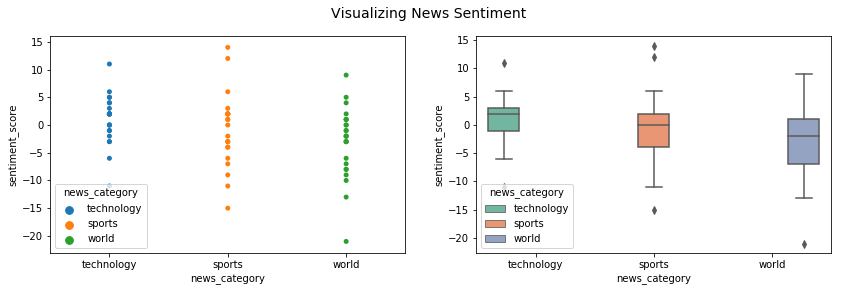

In [67]:

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 4))
sp = sns.stripplot(x='news_category', y="sentiment_score", 
                   hue='news_category', data=df, ax=ax1)
bp = sns.boxplot(x='news_category', y="sentiment_score", 
                 hue='news_category', data=df, palette="Set2", ax=ax2)
t = f.suptitle('Visualizing News Sentiment', fontsize=14)

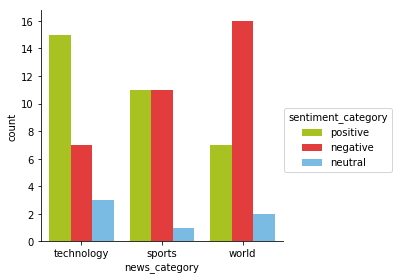

In [68]:
fc = sns.factorplot(x="news_category", hue="sentiment_category", 
                    data=df, kind="count", 
                    palette={"negative": "#FE2020", 
                             "positive": "#BADD07", 
                             "neutral": "#68BFF5"})

In [70]:
pos_idx = df[(df.news_category=='technology') & (df.sentiment_score == 6)].index[0]
neg_idx = df[(df.news_category=='technology') & (df.sentiment_score == -11)].index[0]

print('Most Negative Tech News Article:', news_df.iloc[neg_idx][['news_article']][0])
print()
print('Most Positive Tech News Article:', news_df.iloc[pos_idx][['news_article']][0])

Most Negative Tech News Article: After TRAI Chairman RS Sharma challenged hackers to access his personal information using his Aadhaar number, his daughter Kavita Sharma on Monday received an e-mail threatening her of regretful consequences. The sender warned her father's information would be made public if a ransom is not paid. Two of RS Sharma's e-mail addresses were also included in the threatening e-mail.

Most Positive Tech News Article: US-based manufacturer Corning has developed 'Gorilla Glass 6' for smartphones that can survive up to 15 drops onto rough surfaces from one-metre height. The new glass is said to be two times stronger than its predecessor and is Corning's most durable cover glass to date. It is also designed for wireless charging, apart from being scratch resistant and water-proof.


#### Sentiment Analysis with TextBlob

In [71]:
from textblob import TextBlob

# compute sentiment scores (polarity) and labels
sentiment_scores_tb = [round(TextBlob(article).sentiment.polarity, 3) for article in news_df['clean_text']]
sentiment_category_tb = ['positive' if score > 0 
                             else 'negative' if score < 0 
                                 else 'neutral' 
                                     for score in sentiment_scores_tb]


# sentiment statistics per news category
df = pd.DataFrame([list(news_df['news_category']), sentiment_scores_tb, sentiment_category_tb]).T
df.columns = ['news_category', 'sentiment_score', 'sentiment_category']
df['sentiment_score'] = df.sentiment_score.astype('float')
df.groupby(by=['news_category']).describe()

sentiment_score                                            \
                        count      mean       std    min     25%    50%   
news_category                                                             
sports                   23.0  0.010957  0.127249 -0.258 -0.0475  0.000   
technology               25.0  0.012800  0.213416 -0.467 -0.0680  0.067   
world                    25.0 -0.000520  0.173222 -0.271 -0.1500  0.010   

                             
                 75%    max  
news_category                
sports         0.047  0.388  
technology     0.150  0.281  
world          0.143  0.267

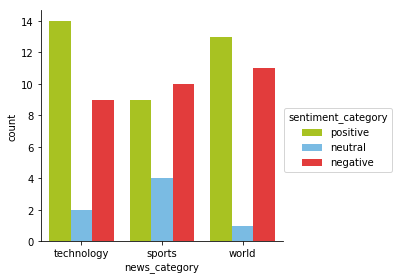

In [72]:
fc = sns.factorplot(x="news_category", hue="sentiment_category", 
                    data=df, kind="count", 
                    palette={"negative": "#FE2020", 
                             "positive": "#BADD07", 
                             "neutral": "#68BFF5"})